In [1]:
import numpy as np
import tensorflow as tf

import os

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

from scipy.interpolate import interp1d
from scipy import signal
from scipy.integrate import solve_ivp

from sklearn.model_selection import train_test_split

# Make sure interactive plotting is enabled
%matplotlib widget

# Load data from full simulations

## Units

$$[d] = \mathrm{mm}$$
$$[p] = \mathrm{MPa}$$
$$[m] = \mathrm{Ton}$$
$$[f] = \mathrm{N}$$
$$[t] = \mathrm{s}$$


In [2]:
def load_multiple_records(file_path):
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    records = []
    current_record = []
    header = lines[0].strip()  # Assuming the first line is the header
    
    for line in lines:
        if line.strip() == header:
            if current_record:
                records.append(np.array(current_record, dtype=float))
                current_record = []
        else:
            current_record.append([float(value) for value in line.split()])
    
    if current_record:  # Add the last record if the file doesn't end with a header line
        records.append(np.array(current_record, dtype=float))
    
    return records

In [3]:
# Folder path where the files are stored
folder_path = r'C:\Users\joses\Mi unidad\TRABAJO\48_FG_protection\TRABAJO\fgp_optimizer\optimization_simple_plastic\full_simulation_data\iter0'
folder_path_presion_losa = os.path.join(folder_path, 'presion_losa')
folder_path_presion_chapa = os.path.join(folder_path, 'presion_chapa')
folder_path_flecha_losa = os.path.join(folder_path, 'flecha_losa')


# Dictionary to store the data for each node
data_dicts = {}
node_ids = []
nodes = np.loadtxt(os.path.join(folder_path, 'nodos.txt'))[:, 1:]

# Iterate over each file in the folder
for filename in os.listdir(folder_path_presion_losa):
    if filename.startswith('presion_node'):
        # Extract the node ID from the filename
        node_id = filename.split(' ')[-1]
        node_ids.append(node_id)
        
        # Construct the full file path
        file_path_presion_losa = os.path.join(folder_path_presion_losa, filename)
        file_path_flecha_losa = os.path.join(folder_path_flecha_losa, filename.replace('presion_node ', 'flecha_node'))
        
        # Load the data, skipping the first line
        data = load_multiple_records(file_path_presion_losa)
        
        # Store the time and pressure data in the dictionary under the node_id
        data_dicts[node_id] = {
            'time': data[0][:, 0],
            'pressure': -np.mean(np.array(data), axis=0)[:,1],
            'displacement': np.loadtxt(file_path_flecha_losa, skiprows=1)[:, 1], 
            'coordinates': nodes[int(node_id)]
        }


In [4]:
data_dicts[node_id]['displacement'].shape

(10002,)

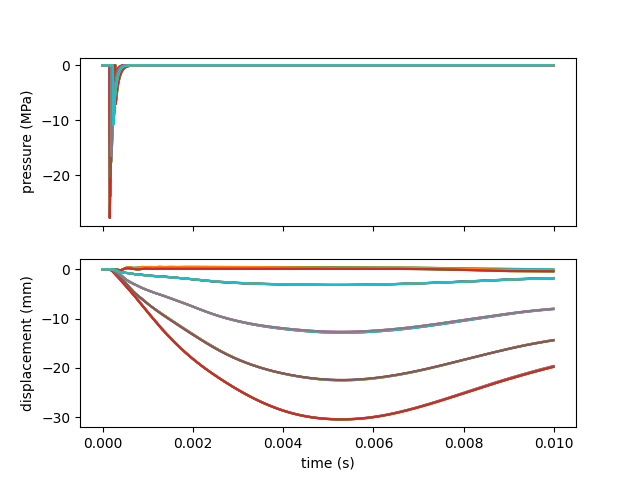

x_s_max_hf = 0.030513471603 m


In [5]:
fig1, ax1 = plt.subplots(2, 1, sharex='col')
ax1 = ax1.flatten()

n_rows = 1000
for node_id in node_ids:
    ax1[0].plot(data_dicts[node_id]['time'][:n_rows], data_dicts[node_id]['pressure'][:n_rows])
    ax1[0].set_ylabel('pressure (MPa)')
    ax1[1].plot(data_dicts[node_id]['time'][:n_rows], data_dicts[node_id]['displacement'][:n_rows])
    ax1[1].set_ylabel('displacement (mm)')
    ax1[1].set_xlabel('time (s)')
plt.show()

print(f"x_s_max_hf = {1e-3*np.max(np.abs(np.array([data_dicts[node_id]['displacement'] for node_id in node_ids]).ravel()))} m")

In [6]:
np.max(np.array([data_dicts[node_id]['displacement'] for node_id in node_ids]))

0.50132411718

In [7]:
np.mean(np.diff(data_dicts[node_id]['time']))

9.999022598740127e-06

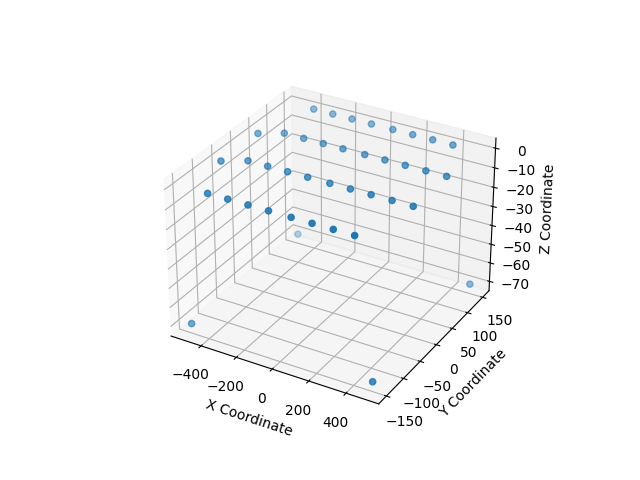

In [8]:
coordinates = np.array([data_dicts[node_id]['coordinates'] for node_id in node_ids])

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])

# Set labels (optional)
ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')

plt.show()

In [9]:
stride = 10

# Assuming data_dicts and node_ids are already defined
coordinates = np.array([data_dicts[node_id]['coordinates'] for node_id in node_ids])
displacement_data = np.array([data_dicts[node_id]['displacement'][:n_rows] for node_id in node_ids])
pressure_data = np.array([data_dicts[node_id]['pressure'][:n_rows] for node_id in node_ids])
time_data = np.array(data_dicts[node_ids[0]]['time'][:n_rows])

# # Create a 3D scatter plot
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')

# # Initialize scatter plot
# scat = ax.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2])

# # Set labels (optional)
# ax.set_xlabel('X Coordinate')
# ax.set_ylabel('Y Coordinate')
# ax.set_zlabel('Z Coordinate')

# # Function to update the scatter plot
# def update(frame):
#     ax.clear()
#     ax.set_xlabel('X Coordinate')
#     ax.set_ylabel('Y Coordinate')
#     ax.set_zlabel('Z Coordinate')
#     ax.set_xlim([coordinates[:, 0].min(), coordinates[:, 0].max()])
#     ax.set_ylim([coordinates[:, 1].min(), coordinates[:, 1].max()])
#     ax.set_zlim([displacement_data.min(), displacement_data.max()])
#     ax.scatter(coordinates[:, 0], coordinates[:, 1], displacement_data[:, frame], c=pressure_data[:, frame], cmap='hot')
#     return scat,

# # Create the animation
# ani = FuncAnimation(fig, update, frames=range(0, len(displacement_data[0]), stride), interval=1000/25, blit=False)

# HTML(ani.to_jshtml())


In [10]:
print(f'{time_data.shape=}')

time_data.shape=(1000,)


In [11]:
print(f'{displacement_data.shape=}')

displacement_data.shape=(40, 1000)


In [12]:
print(f'{pressure_data.shape=}')

pressure_data.shape=(40, 1000)


# Train set generation from time history dataset

## Get maximum displacement and force

In [13]:
pressure_flag = 'mean'  # 'max' 

i_node_max = np.argmax(np.abs(np.max(np.abs(displacement_data), axis=1)))
disp = displacement_data[i_node_max, :]  # mm

length = 840
width = 300
print(f'{length=}, {width=}')
area = length*width

if pressure_flag == 'mean':
    force = np.mean(pressure_data, axis=0) * area  # MPa mm mm = 10e6 (N / m^2) (10e-3)^2 m^2 = N
elif pressure_flag == 'max':
    node_max_pressure = np.argmax(np.abs(np.mean(pressure_data, axis=1)))
    force = pressure_data[node_max_pressure, :] * area  # MPa mm mm = 10e6 (N / m^2) (10e-3)^2 m^2 = N
else:
    raise NotImplementedError

print(f'{disp.shape=}, {force.shape=}')

length=840, width=300
disp.shape=(1000,), force.shape=(1000,)


## Resampling to a constant delta_t

In [14]:
# Fix delta_t
delta_t_real = np.round(np.mean(np.diff(time_data)), 5)/1
print(f'{delta_t_real=}')

# New time vector
time_resampled_ = np.arange(time_data[0], time_data[-1], delta_t_real)

# Create an interpolation function
interp_disp_func = interp1d(time_data, disp, kind='cubic', fill_value="extrapolate")

interp_force_func = interp1d(time_data, force, kind='cubic', fill_value="extrapolate")

smoothing_window = 4

# Resample values using the interpolation function
disp_resampled_ = interp_disp_func(time_resampled_)
disp_resampled = signal.convolve(disp_resampled_, np.ones((smoothing_window))/smoothing_window, mode='valid')
force_resampled_ = interp_force_func(time_resampled_)
force_resampled = signal.convolve(force_resampled_, np.ones((smoothing_window))/smoothing_window, mode='valid')
time_resampled = time_resampled_[smoothing_window//2:-smoothing_window//2+1]

print(f'{time_resampled_.shape=}')
print(f'{time_resampled.shape=}')

print(f'{disp_resampled_.shape=}')
print(f'{disp_resampled.shape=}')
print(f'{force_resampled_.shape=}')
print(f'{force_resampled.shape=}')

delta_t_real=1e-05
time_resampled_.shape=(999,)
time_resampled.shape=(996,)
disp_resampled_.shape=(999,)
disp_resampled.shape=(996,)
force_resampled_.shape=(999,)
force_resampled.shape=(996,)


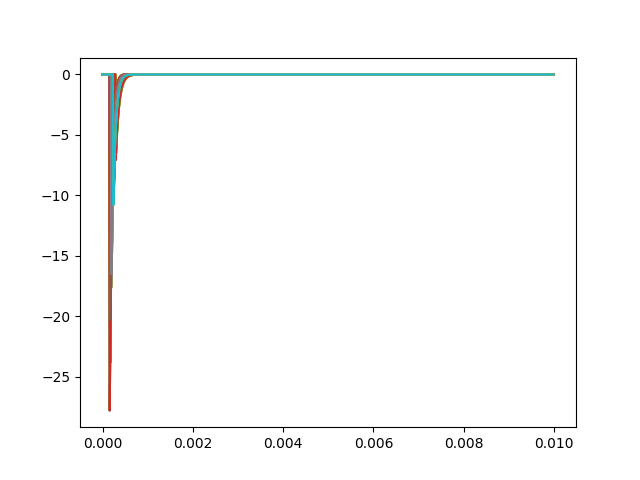

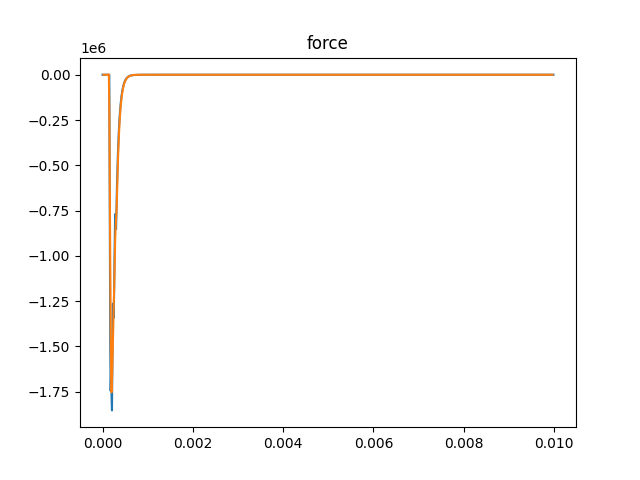

In [15]:
plt.figure()
plt.plot(time_data, pressure_data.T)
plt.show()

plt.figure()
plt.plot(time_data, force)
plt.plot(time_resampled, force_resampled)
plt.title('force')
plt.show()

### Scaling

In [16]:
scales = {'time': 1e3,
          'force': 1e-7,
          'disp': 1e-2}


# Re-scale displacement
disp_resampled_norm = disp_resampled * scales['disp']

# Re-scale time vector for appropriate scaling
time_resampled_norm = time_resampled * scales['time']
delta_t_norm = time_resampled_norm[1] - time_resampled_norm[0]

# Re-scale force
force_resampled_norm = force_resampled * scales['force']

## Velocity estimation

In [17]:
vel_resampled_norm = np.diff(disp_resampled_norm, prepend=0)/delta_t_norm

## Acceleration estimation

In [18]:
acc_resampled_norm = np.diff(vel_resampled_norm, prepend=0)/delta_t_norm

In [19]:
disp_resampled_norm.shape

(996,)

### Plots for inspecting resampling

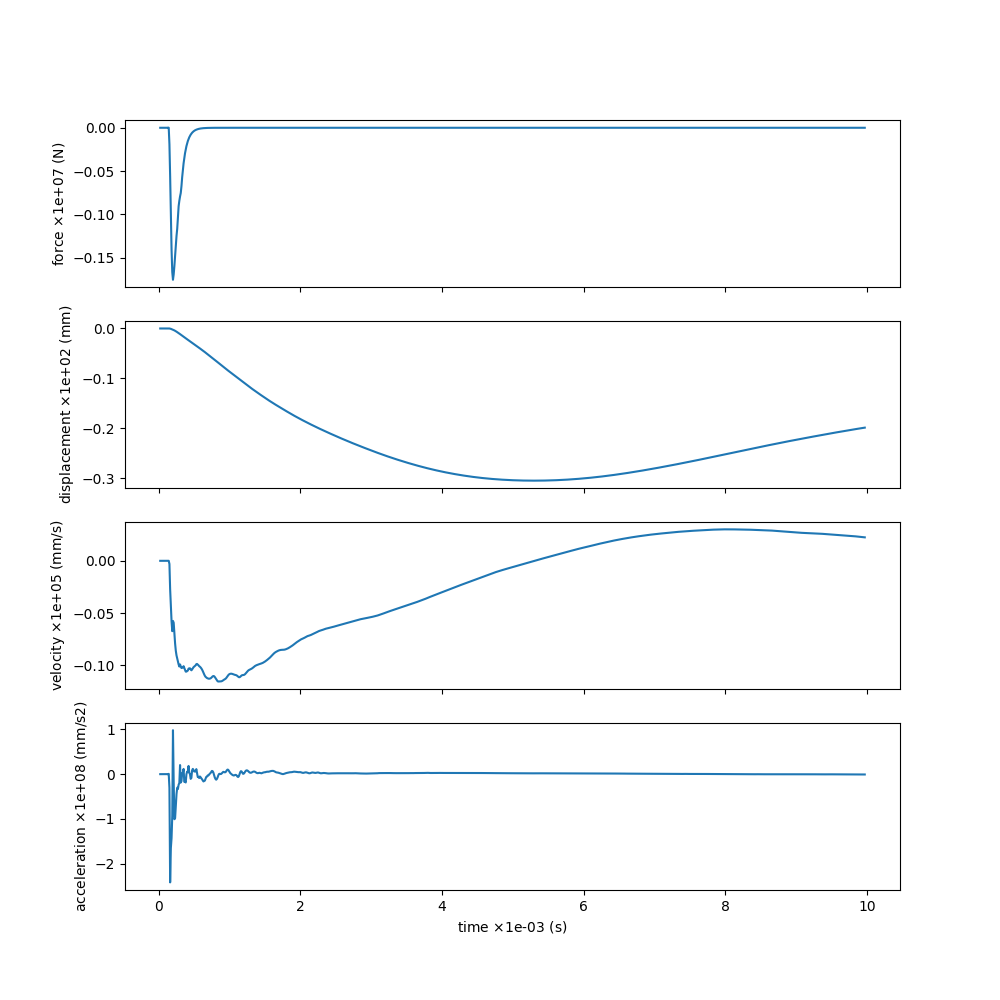

In [20]:
fig2, ax2 = plt.subplots(4, 1, figsize=(10,10), sharex='col')
ax2 = ax2.flatten()

ax2[0].plot(time_resampled_norm, force_resampled_norm.T)
ax2[0].set_ylabel(fr'force $\times${1/scales["force"]:.0e} (N)')
ax2[1].plot(time_resampled_norm, disp_resampled_norm.T)
ax2[1].set_ylabel(fr'displacement $\times${1/scales["disp"]:.0e} (mm)')
ax2[2].plot(time_resampled_norm, vel_resampled_norm.T)
ax2[2].set_ylabel(fr'velocity $\times${(1/scales["disp"])/(1/(scales["time"])):.0e} (mm/s)')
ax2[3].plot(time_resampled_norm, acc_resampled_norm.T)
ax2[3].set_ylabel(fr'acceleration $\times${(1/scales["disp"])/(1/(scales["time"]**2)):.0e} (mm/s2)')
ax2[3].set_xlabel(fr'time $\times${(1/scales["time"]):.0e} (s)')

plt.show()

# First approximation using supervised learning

In [21]:
from scipy.optimize import nnls


# Stack x_ddot, x_dot, and x into a matrix for regression
X_lr = np.vstack([acc_resampled_norm, vel_resampled_norm, disp_resampled_norm]).T  # Shape (n_samples, 3)

# Fit the linear model: f = m * x_ddot + c * x_dot + k * x
coefs, _ = nnls(X_lr, force_resampled_norm)

# Get the coefficients
m, c, k = coefs

print(f"Estimated mass (m): {m}")
print(f"Estimated damping (c): {c}")
print(f"Estimated stiffness (k): {k}")

Estimated mass (m): 0.06596766794598118
Estimated damping (c): 0.06643644292183008
Estimated stiffness (k): 0.0016325837786634986


### Verification

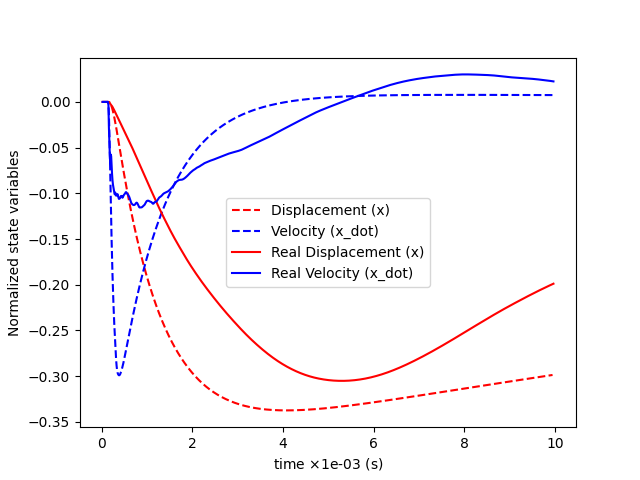

In [22]:
def solve_system(m, c, k, force, time):
    # Define the system dynamics
    def dynamics(y, f_t):
        x, x_dot = y
        x_ddot = (f_t - c * x_dot - k * x) / m
        return [x_dot, x_ddot]

    # Define the external force as a function of time 
    def force_t(t):
        return force.reshape((-1,1))[np.where(time > t)[0][0], :][0]

    # Wrapper for `solve_ivp` to include the force term
    def wrapped_dynamics(t, y, force_t):
        return dynamics(y, force_t(t))

    # Solve the ODE
    sol = solve_ivp(wrapped_dynamics, y0=np.zeros((2, )), t_span=[0, time[-2]], t_eval=time[:-2], args=[force_t])
    return sol

# Solve the system
sol = solve_system(m, c, k, force_resampled_norm, time_resampled_norm)

# Plot the results
plt.figure()
plt.plot(sol.t, sol.y[0], color='red', linestyle='--', label='Displacement (x)')
plt.plot(sol.t, sol.y[1], color='blue', linestyle='--', label='Velocity (x_dot)')
plt.plot(time_resampled_norm, disp_resampled_norm, color='red', linestyle='-', label='Real Displacement (x)')
plt.plot(time_resampled_norm, vel_resampled_norm, color='blue', linestyle='-', label='Real Velocity (x_dot)')
plt.xlabel(fr'time $\times${(1/scales["time"]):.0e} (s)')
plt.ylabel('Normalized state variables')
plt.legend()
plt.show()

## Refine model using Reinforcement Learning

In [23]:
from scipy.optimize import minimize, differential_evolution


# Save a copy of proxy
m_init, c_init, k_init = m, c, k

# Objective function to minimize
def objective(params, disp_resampled_norm, time_resampled_norm):
    # Unpack the parameters for this evaluation
    m, c, k = params

    # Solve the system
    sol = solve_system(m, c, k, force_resampled_norm, time_resampled_norm)
    
    try:
        error = np.sum(np.abs(sol.y[0] - disp_resampled_norm[:-2]))
        # error = np.sum((sol.y[0] - disp_resampled_norm[:-2])**2)
    except IndexError:
        error = np.inf

    return error

# Initial guess for m, c, k
initial_guess = [m_init, c_init, k_init]

# Optimize parameters

result = differential_evolution(objective, bounds=[(.10*m_init, 10*m_init), (.10*c_init, 10*c_init), (.10*k_init, 10*k_init)], 
                                args=(disp_resampled_norm, time_resampled_norm), tol=1e-3)

m, c, k = result.x

print(f"Optimized mass (m): {m}")
print(f"Optimized damping (c): {c}")
print(f"Optimized stiffness (k): {k}")

Optimized mass (m): 0.18403530873195698
Optimized damping (c): 0.042059599666658905
Optimized stiffness (k): 0.010425550103927636


### Verification

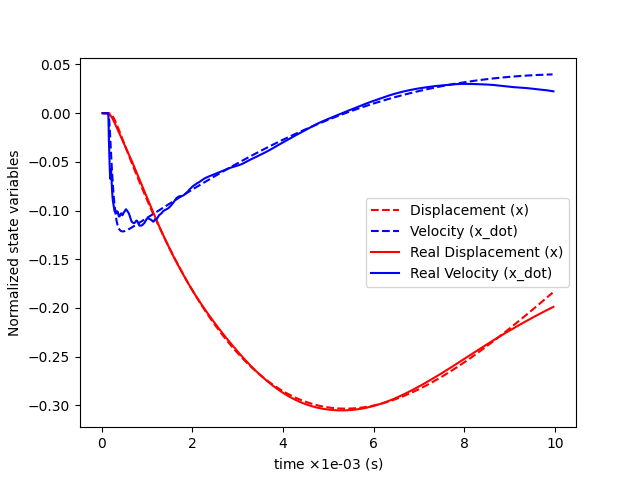

In [24]:
# Solve the system
sol = solve_system(m, c, k, force_resampled_norm, time_resampled_norm)

# Plot the results
plt.figure()
plt.plot(sol.t, sol.y[0], color='red', linestyle='--', label='Displacement (x)')
plt.plot(sol.t, sol.y[1], color='blue', linestyle='--', label='Velocity (x_dot)')
plt.plot(time_resampled_norm, disp_resampled_norm, color='red', linestyle='-', label='Real Displacement (x)')
plt.plot(time_resampled_norm, vel_resampled_norm, color='blue', linestyle='-', label='Real Velocity (x_dot)')
plt.xlabel(fr'time $\times${(1/scales["time"]):.0e} (s)')
plt.ylabel('Normalized state variables')
plt.legend()
plt.show()

# Back to physical units

In [25]:
m_Ton = m * (1/scales['force']) / ((1/scales['disp']) / (1/scales['time']**2)) 
c_Ns_mm = c * (1/scales['force']) / ((1/scales['disp']) / (1/scales['time']))
k_N_mm = k * (1/scales['force']) / (1/scales['disp'])
omega_rad_s = np.sqrt((k_N_mm*1000) / (m_Ton*1000))

print(f'{m_Ton=:.4f}, {c_Ns_mm=:.4f}, {k_N_mm=:.4f}')
print(f'm_s = {m_Ton*1000=:.4f} kg')
print(f'k_s = {k_N_mm*1000=:.4f} N/m')
print(f'c_s = {c_Ns_mm*1000=:.4f} Ns/m')
print(f'omega = {omega_rad_s=:.4f} rad/s')
print(f'frequency = {omega_rad_s/(2*np.pi)=:.4f} Hz')
print(f'period = {1/(omega_rad_s/(2*np.pi))=:.4f} s')
print(f'damping ratio = {(c_Ns_mm*1000)/(2*(m_Ton*1000)*omega_rad_s)}')

m_Ton=0.0184, c_Ns_mm=4.2060, k_N_mm=1042.5550
m_s = m_Ton*1000=18.4035 kg
k_s = k_N_mm*1000=1042555.0104 N/m
c_s = c_Ns_mm*1000=4205.9600 Ns/m
omega = omega_rad_s=238.0120 rad/s
frequency = omega_rad_s/(2*np.pi)=37.8808 Hz
period = 1/(omega_rad_s/(2*np.pi))=0.0264 s
damping ratio = 0.4801037211240573


## Verification

### Using the original force load

In [26]:
# Solve the system
sol_phys = solve_system(m_Ton, c_Ns_mm, k_N_mm, force_resampled, time_resampled)

### Using an approximated triangle force load

t_ini_=0.00016089108875894098 s, T_=0.0002631086356957898 s, F_=-1753384.9570321564 N
Impulse: -230.66536194712586 Ns


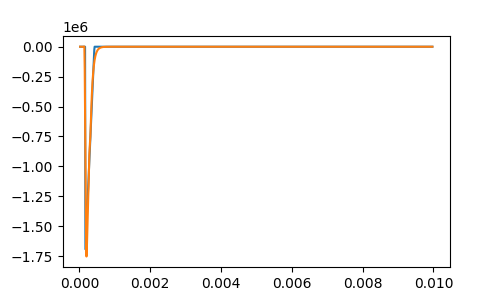

In [27]:
def triangle_force(t_eval: float, t_ini: float, T: float, F: float) -> float:
    """
    Calculates the force with an instantaneous rise to F followed by a gradual 
    decrease over time T.
    
    Args:
        t_eval (float): The time at which the force is evaluated.
        t_ini (float): The start time of the force impulse.
        T (float): The total duration of the fall.
        F (float): The peak value of the force.
    
    Returns:
        float: The value of the force at time t_eval.
    """
    
    # Time elapsed since the start of the impulse
    delta_t = t_eval - t_ini

    if delta_t < 0 or delta_t > T:
        # Outside the force application period
        return 0.0
    elif delta_t == 0:
        # Instantaneous rise at the start
        return F
    else:
        # Gradual fall from F to 0 over time T
        return F * (1 - delta_t / T)

triangle_force_vectorized = np.vectorize(triangle_force)

# Detect the peak no mater whether is positive or negative
peak_idx = np.argmax(np.abs(force_resampled))
F_ = force_resampled[peak_idx]

def obj_triangle(params: list, t_vector: np.array, f_vector: np.array, F_):
    # Extract parameters to be optimized
    t_ini, T = params

    error = f_vector - triangle_force_vectorized(t_vector, t_ini, T, F_)
    return np.linalg.norm(error)

    
result_triangle = differential_evolution(obj_triangle, 
                                         [(0, time_resampled[-1]), (1e-6, 1e-3)],
                                         args=(time_resampled, force_resampled, F_), disp=False)

t_ini_, T_ = result_triangle.x
print(f'{t_ini_=} s, {T_=} s, {F_=} N')
print(f'Impulse: {F_*T_/2} Ns')

force_resampled_triangle = triangle_force_vectorized(time_resampled, t_ini_, T_, np.min(force_resampled))

# Plot for verification of proxy solution
plt.figure(figsize=(5,3))
plt.plot(time_resampled, force_resampled_triangle)
plt.plot(time_resampled, force_resampled)
plt.show()

In [28]:
# Solve the system
sol_phys_triangle = solve_system(m_Ton, c_Ns_mm, k_N_mm, force_resampled_triangle, time_resampled)

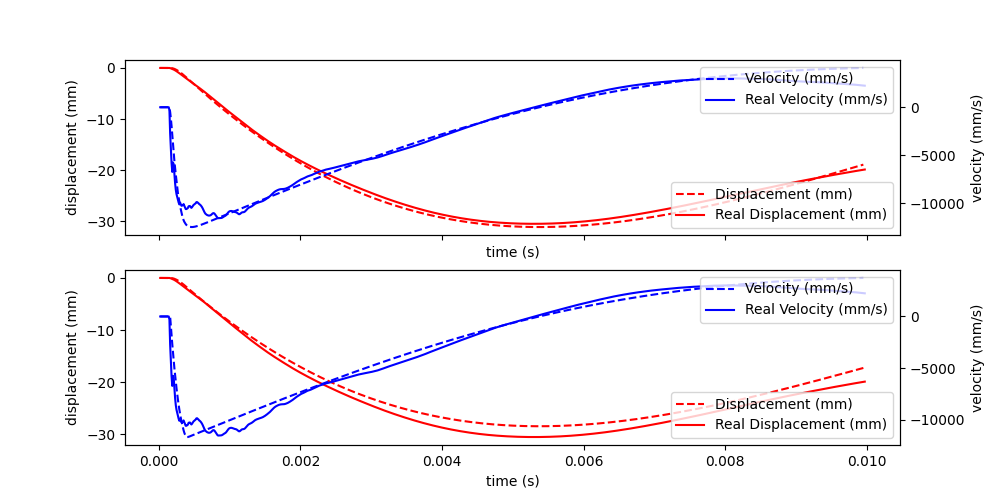

In [29]:
# Plot the results
fig, ax = plt.subplots(2,1, figsize=(10,5), sharex='col')
ax_twin = ax[0].twinx(), ax[1].twinx() 


def plot_sol_phys(sol_phys_, ax, ax_twin, i, m_mm: str = 'mm'):
    if m_mm == 'm':
        sol_phys_.y[0] = 1000*sol_phys_.y[0]
        sol_phys_.y[1] = 1000*sol_phys_.y[1]

    ax[i].plot(sol_phys_.t, sol_phys_.y[0], color='red', linestyle='--', label='Displacement (mm)')
    ax[i].plot(time_resampled, disp_resampled, color='red', linestyle='-', label='Real Displacement (mm)')
    ax_twin[i].plot(sol_phys_.t, sol_phys_.y[1], color='blue', linestyle='--', label='Velocity (mm/s)')
    ax_twin[i].plot(time_resampled, np.diff(disp_resampled, prepend=0)/delta_t_real, color='blue', linestyle='-', label='Real Velocity (mm/s)')
    ax_twin[i].set_ylabel('velocity (mm/s)')
    ax[i].set_ylabel('displacement (mm)')
    ax[i].legend(loc='lower right')
    ax_twin[i].legend(loc='upper right')
    ax[i].set_xlabel('time (s)')

plot_sol_phys(sol_phys, ax, ax_twin, 0)
plot_sol_phys(sol_phys_triangle, ax, ax_twin, 1)

plt.show()